In [36]:
# !pip install transformers
# !pip install datasets

In [2]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
! pip install -q kaggle

In [4]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shumshersubash2018","key":"b4bcbd1b30703165f00faf907d41f842"}'}

In [5]:
 ! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 95.8MB/s]


In [10]:
# !unzip /content/hate-speech-and-offensive-language-dataset.zip

In [11]:
# DATA_PATH = "labeled_data.csv" # In Colab

# DATA_PATH = '/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv' # In Kaggle

DATA_PATH = "/content/labeled_data.csv" # Local Machine

In [12]:
# pandas_df = pd.read_csv("labeled_data.csv")
pandas_df = pd.read_csv(DATA_PATH)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: xlabel='class', ylabel='count'>

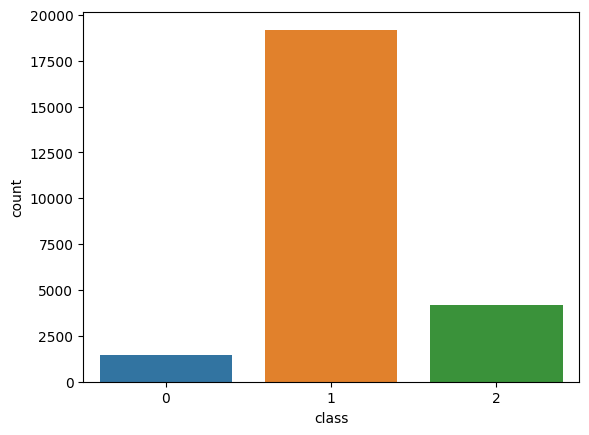

In [14]:
import seaborn as sns
sns.countplot(x='class', data=pandas_df)

In [15]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


# **Load dataframe from Pandas**

In [16]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [17]:
dataset = load_dataset('csv', data_files=DATA_PATH, split='train')

dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [18]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither','Unnamed: 0', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

# **Tokenizer**

In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [20]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [21]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [22]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [23]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [24]:
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [25]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

In [26]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [27]:
 train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

In [28]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model =test_set_for_final_model.batch(8)

In [29]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
# model = TFAutoModelForSequenceClassification.from_pretrained("/mnt/e0ccdbdb-22c3-4d9b-9413-fd976a2e99ae/M1/Code_Org/HF_Models/bert-base-uncased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3 )

Epoch 1/3
2324/2324 [==============================] - 2399s 1s/step - loss: 0.3063 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.9027
Epoch 2/3
2324/2324 [==============================] - 2332s 1s/step - loss: 0.2602 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.8986
Epoch 3/3
2324/2324 [==============================] - 2329s 1s/step - loss: 0.2393 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.3023 - val_sparse_categorical_accuracy: 0.9029


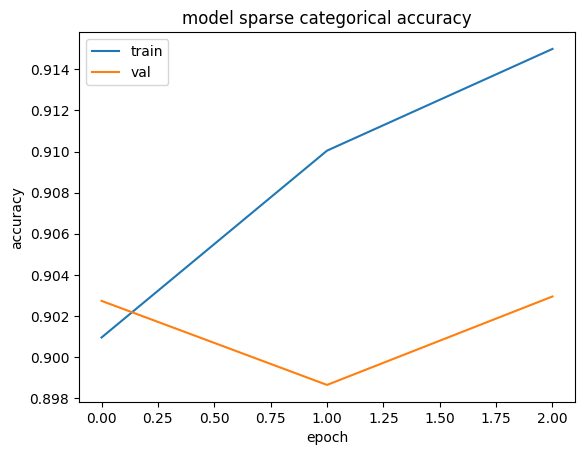

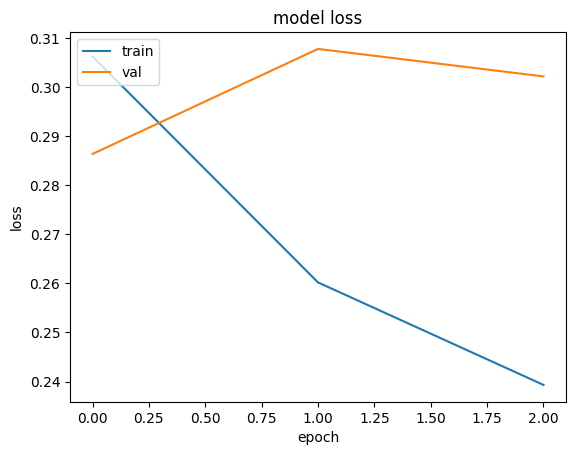

In [31]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:', test_acc)

194/194 - 66s - loss: 0.2777 - sparse_categorical_accuracy: 0.9070 - 66s/epoch - 341ms/step

Test accuracy: 0.9070367813110352


In [34]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}

preds = model(tokenizer(["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"],return_tensors="tf",padding=True,truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

tf.Tensor(
[[-0.7379736  -0.5830973   0.76563805]
 [-0.97632754 -0.37221816  0.91340864]
 [ 0.22166954  1.529616   -2.7521358 ]], shape=(3, 3), dtype=float32)
Neither
Neither
Offensive Language


In [35]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}
preds = model(tokenizer(["He dresses up like a begger thise days"],return_tensors="tf",padding=True,truncation=True))['logits']
print(preds)
class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

tf.Tensor([[-0.5391794  -0.62866527  0.4956373 ]], shape=(1, 3), dtype=float32)
Neither
